## DESI Throughput

The attached figure shows an estimate of the throughput derived from the fiber giving the highest throughput (presumably because closest to its target; this is fiber #307) on exposure #29181. Compared to simulations, we are still missing a factor 2.

This is very preliminary. Alternative analyses are more than welcome.
The spectra are there:
/project/projectdirs/desi/spectro/redux/daily/exposures/20191117/00029181/
(look at b3,r3,z3)
And the fiberassign file is here :
/project/projectdirs/desi/spectro/data/20191116/00028818/fiberassign-063064.fits
(several copies of the same file in different exposures)

In [19]:
import os, pdb
import numpy as np
import fitsio

In [2]:
from astropy.table import Table

In [3]:
import desimodel.io

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='talk', style='ticks', font_scale=1.1)
colors = sns.color_palette()
%matplotlib inline

In [5]:
allnight = '20200102'
outdir = os.path.join(os.getenv('DESI_ROOT'), 'ioannis', 'throughput')

In [205]:
datadir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'data')
reduxdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'redux', 'daily', 'exposures')

In [7]:
fiberfile = os.path.join(datadir, '20200102', '00037738', 'fiberassign-063511.fits')
#Table(fitsio.read(fiberfile))

In [198]:
import json
requestsfile = '/Users/ioannis/work/desi/spectro/data/20200102/00037742/request-00037742.json'
with open(requestsfile) as ff:
    jj = json.load(ff)
print(jj.keys())
print(jj['PASSTHRU'])
int(jj['PASSTHRU'].split(':')[3].split(',')[0])

dict_keys(['SEQUENCE', 'FLAVOR', 'OBSTYPE', 'CORRECT_FOR_ADC', 'USETEMP', 'USELUT', 'EXPTIME', 'PASSTHRU', 'PROGRAM', 'DELTARA', 'DELTADEC', 'TRACK', 'OFFSET_TYPE', 'INVALID', 'EXCLUDED', 'REQUIRED', 'EPOCH', 'GUIDER_MODE', 'WAIT', 'COUNT', 'MANIFEST', 'OBJECT', 'PM_STEP', 'SIMULATEMOVES', 'LEAD', 'PROPID', 'OBSERVER', 'DISPLAY', 'SEQNUM', 'ID', 'UID'])
{ OFFSTRA:1, OFFSTDEC:1, TILEID:63511, TILERA:122, TILEDEC:39.5 }


63511

In [8]:
desimodel.io.load_focalplane()[0]

PETAL,DEVICE,LOCATION,PETAL_ID,DEVICE_ID,DEVICE_TYPE,SLITBLOCK,BLOCKFIBER,CABLE,CONDUIT,FIBER,FWHM,FRD,ABS,OFFSET_X,OFFSET_Y,OFFSET_T,OFFSET_P,LENGTH_R1,LENGTH_R2,MAX_T,MIN_T,MAX_P,MIN_P
,,,,,,,,,,,,,,mm,mm,degrees,degrees,mm,mm,degrees,degrees,degrees,degrees
int32,int32,int32,int32,str6,str3,int32,int32,int32,str2,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7,0,7000,2,M03139,POS,18,20,0,A0,3970,2.13,90.95,102.25,-25.81851546044606,12.328919779295408,-12.798896202115827,-7.332998043480714,3.0499512408361067,3.0906526593725245,196.29145210382842,-196.29145210382842,185.0,-6.510237122851066
7,1,7001,2,M03621,POS,18,4,0,A0,3954,1.48,93.01,99.23,-34.24598804414511,18.451823418204235,61.966170695770344,-3.6252490292243067,2.8973788308977952,3.10304676910012,197.48776528205983,-197.48776528205983,185.0,-3.7366336014804347
7,2,7002,2,M03500,POS,18,21,0,A0,3971,1.46,93.08,100.44,-35.35336376572603,8.067607832475183,153.95265866761594,-9.298252853748409,2.9891109127605695,3.0094555955645257,196.09305773538108,-196.09305773538108,185.0,-9.904784808313366
7,3,7003,2,M03730,POS,18,13,0,A0,3963,1.81,92.0,101.8,-42.67337200252829,24.574660194916063,-24.71395651372555,6.7960858525957235,2.9226227713822595,3.1353688539582794,196.25296894295718,-196.25296894295718,185.0,-3.200058547407167
7,4,7004,2,M03430,POS,18,17,0,A0,3967,1.94,91.59,99.71,-43.78214641435156,14.188635165735029,254.14859696481045,-5.942813475256685,3.0412955303327887,3.074251001486179,196.97921998660289,-196.97921998660289,185.0,-2.108507464073625
7,5,7005,2,M02702,POS,19,0,0,A0,3975,2.3,90.38,98.4,-51.100673731821566,30.69742981228919,309.08985695604093,-5.269775014690964,3.0316971171669627,3.1440202897681977,196.32101187186942,-196.32101187186942,185.0,-3.9369307553631074
7,6,7006,2,M02813,POS,19,23,0,A0,3998,1.97,91.49,97.91,-52.209867804888624,20.31094455877104,280.4442706858896,-5.959487340028119,2.9977219103883415,3.105887840846827,195.01387036492014,-195.01387036492014,185.0,-7.822787584932598
7,7,7007,2,M03426,POS,18,22,0,A0,3972,2.1,91.07,99.56,-53.3373030713626,9.895378215863193,323.59993756026404,-2.2734298757119973,2.987717970362263,3.075180781273822,195.45337276363483,-195.45337276363483,185.0,-5.811631484441932


In [260]:
def read_and_stack_nightwatch(allnight, verbose=False, overwrite=False):
    """Read and stack all the nightwatch QA files for a given (input) set of nights.
    
    """
    from glob import glob
    import astropy.table
    
    nightmin, nightmax = np.min(int(allnight)), np.max(int(allnight))
    stackwatchfile = os.path.join(outdir, 'qa-nightwatch-{}-{}.fits'.format(str(nightmin), str(nightmax)))
    if os.path.isfile(stackwatchfile) and not overwrite:
        print('Reading {}'.format(stackwatchfile))
        allqa = Table(fitsio.read(stackwatchfile))
    else:
        print('Reading the focal plane model.')
        fp = desimodel.io.load_focalplane()[0]
        fp = fp['PETAL', 'FIBER', 'OFFSET_X', 'OFFSET_Y']
        
        nightwatchdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'nightwatch', 'kpno')
        for night in np.atleast_1d(allnight):
            nightdir = os.path.join(nightwatchdir, night)
            allexpiddir = glob(os.path.join(nightdir, '????????'))
            
            # Need to assign fiberassign files algorithmically...
            #tilefile = os.path.join(datadir, night, os.path.basename(exp)
            #                         '00037738', 'fiberassign-063511.fits')
            #tile = Table(fitsio.read(fiberfile))

            allqa = []
            for expiddir in allexpiddir:
                expid = os.path.basename(expiddir)
                qafile = os.path.join(expiddir, 'qa-{}.fits'.format(expid))
                
                # Hack!
                requestfile = os.path.join(datadir, night, 'request-{}.fits'.format(expid))
                tileid = int(jj['PASSTHRU'].split(':')[3].split(',')[0])
                tilefile = glob(os.path.join(datadir, night, '????????', 'fiberassign-{:06d}.fits'.format(tileid)))[0]
                #print(fitsio.FITS(tilefile)['FIBERASSIGN'])
                if verbose:
                    print('Reading {}'.format(tilefile))
                tile = Table(fitsio.FITS(tilefile)['FIBERASSIGN'].read())
                
                if verbose:
                    print('Reading {}'.format(qafile))
                qa = Table(fitsio.read(qafile, 'PER_CAMFIBER'))
                
                # Add the fiberassign info - hack!
                qa = astropy.table.join(qa, tile, keys='FIBER')

                allqa.append(qa)
            allqa = astropy.table.vstack(allqa)

            # Need to update the data model to 'f4'.
            if False:
                print('Updating the data model.')
                for col in allqa.colnames:
                    if allqa[col].dtype == '>f8':
                        allqa[col] = allqa[col].astype('f4')
                    
            # Add the x/y offsets from the focal plane model
            allqa = astropy.table.join(allqa, fp, keys='FIBER')
                    
        print('Writing {}'.format(stackwatchfile))
        fitsio.write(stackwatchfile, allqa.as_array(), clobber=True)
            
    return allqa

In [261]:
allqa = read_and_stack_nightwatch(allnight, verbose=True, overwrite=True)
allqa

Reading the focal plane model.
Reading /Users/ioannis/work/desi/spectro/data/20200102/00037738/fiberassign-063511.fits
Reading /Users/ioannis/work/desi/spectro/nightwatch/kpno/20200102/00037742/qa-00037742.fits
Writing /Users/ioannis/work/desi/ioannis/throughput/qa-nightwatch-20200102-20200102.fits


NIGHT,EXPID,SPECTRO,CAM,FIBER,INTEG_RAW_FLUX,MEDIAN_RAW_FLUX,MEDIAN_RAW_SNR,INTEG_CALIB_FLUX,MEDIAN_CALIB_FLUX,MEDIAN_CALIB_SNR,TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,PETAL,OFFSET_X,OFFSET_Y
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mm,mm
int64,int64,int64,str1,int64,float64,float64,float64,float64,float64,float64,int64,int16,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int32,int16,int32,str8,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,str1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int32,float64,float64
20200102,37742,0,Z,0,391828.38644717744,56.02640151977539,4.714122394036555,-5361.510412569263,-5.775402545928955,-0.44258514393091075,611651768564057149,0,311,311,0,121.58611059677048,38.35458532563501,0.0,0.0,0.0,0.0,0.0,5400.0,4294967296,4,SKY,81.47378,-284.72614,0,0,0.9342606814843144,63,0,8001,535518,1214p382,1085,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030039852,-0.007944582,-0.116994895,0.0,0.0,0.0,0,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,0.0,0.0,,0,0,-1,6458,13.0,8140.6235,2272.019,254.82726,4294967296,0,0,0,83.21897551257103,-286.66372294035915
20200102,37742,0,R,0,88728.2191642539,36.72149658203125,3.0719017985521577,-2497.8392680841266,-1.2976044416427612,-0.10806784134222519,611651768564057149,0,311,311,0,121.58611059677048,38.35458532563501,0.0,0.0,0.0,0.0,0.0,5400.0,4294967296,4,SKY,81.47378,-284.72614,0,0,0.9342606814843144,63,0,8001,535518,1214p382,1085,,0.0,0.0,0.0,0.

#### Find fibers with high S/N spectra.

In [262]:
def select_spectra_snr(data, thiscam='Z', snrcut=10, qaplot=False):
    """Select spectra based on S/N."""
    
    #wcam = np.where(data['CAM'] == thiscam)[0]
    #wgood = np.where((data['MEDIAN_CALIB_SNR'] > snrcut) * (data['CAM'] == thiscam))[0]
    wsnr = np.where((data['MEDIAN_CALIB_SNR'] > snrcut))[0]
    
    isnr = np.where(np.isin(data['FIBER'], data['FIBER'][wsnr]))[0]
    print('Found {} high S/N spectra in {}/{} unique fibers.'.format(
        len(isnr), len(set(data['FIBER'][isnr])), len(set(data['FIBER']))))
    
    #for fib in set(star['FIBER']):
    #    if np.sum(star['FIBER'] == fib) != 3:
    #        print('Problem with fiber {}'.format(fib))    

    if qaplot:
        col = iter(colors)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.plot(data['OFFSET_X'], data['OFFSET_Y'], 'k.',
                ms=1, alpha=0.5, label='')
        for petal in sorted(set(data['PETAL'][isnr])):
            ii = data['PETAL'][isnr] == petal
            ax.scatter(data['OFFSET_X'][isnr][ii], data['OFFSET_Y'][isnr][ii], 
                       marker='o', s=20, color=next(col), label='Petal {}'.format(petal))
        ax.legend(frameon=True, fontsize=12, ncol=1)
        ax.axis('off')
    
    return data[isnr]

Found 222 high S/N spectra in 74/4000 unique fibers.


NIGHT,EXPID,SPECTRO,CAM,FIBER,INTEG_RAW_FLUX,MEDIAN_RAW_FLUX,MEDIAN_RAW_SNR,INTEG_CALIB_FLUX,MEDIAN_CALIB_FLUX,MEDIAN_CALIB_SNR,TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,PETAL,OFFSET_X,OFFSET_Y
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mm,mm
int64,int64,int64,str1,int64,float64,float64,float64,float64,float64,float64,int64,int16,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int16,int32,float64,int32,int32,int16,int32,str8,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,str1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int32,float64,float64
20200102,37742,0,Z,7,2273099.9546530987,966.1140747070312,29.882277483538935,1783463.3184410015,840.7376098632812,26.776016520026424,35191021016976034,0,172,172,0,121.91263915197771,38.577491605121985,3.4899554,-4.8368735,515.9243,1252.8525,2015.5,5400.0,1056,1,TGT,17.38503,-227.42317,0,63,0.9907091125611919,65535,19,8001,536652,1218p385,2722,PSF,2.7918383e+16,5.6341166e+16,0.05124505,521.33746,433.1167,1837.5636,3.6613464,5.487624,0.01047943,0.85924965,0.90286285,0.9444455,3.5336534e-06,9.044815e-06,1.3710386e-06,0.66039306,0.66813314,0.9900598,1.0000008,1.0000006,0.9999977,3,3,4,391.8413,57.16712,0.0,229.3409,36.87103,0.0,3107.2512,1616.2418,296.37604,-169.08484,2.2364106,0.47388726,0.0008224567,1.1158377e-05,0.9913531,0.99468076,0.99886316,0.9995706,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,405.1669,336.60452,1428.096,405.16733,336.6055,1428.0968,0,0,2206,908924451177213952,G2,13.2741995,3599.181,13.807784,356.6262,12.605047,850.1172,1.237523,0.0,False,0.049399763,True,0.24395236,1350.9738,N,1056,63,1,6458,0.0,0.0,0.0,0.0,0,0,0,0,17.3582260537263,-226.7752106709

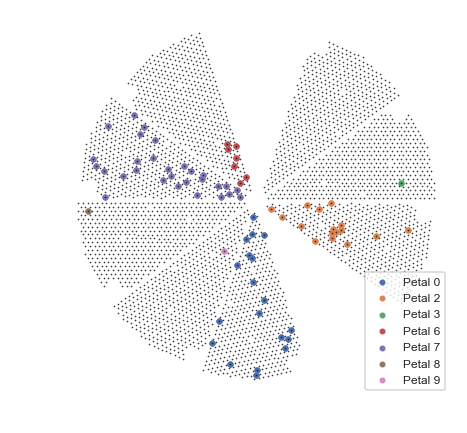

In [263]:
star = select_spectra_snr(allqa, snrcut=10, qaplot=True)
star
#star[star['FIBER'] == 3525]
#star[star['FIBER'] == 7]

In [300]:
def read_one_spectrocam(night, expid, spectrocam, fibers=None, verbose=False):
    """Read a single-camera spectrum for a given night, expid, 
    and spectrograph+camera combination.
    
    """
    import desispec.io
    
    strnight = str(night)
    strexpid = '{:08d}'.format(expid)
    
    specfile = os.path.join(reduxdir, strnight, strexpid, 'sframe-{}-{}.fits'.format(
        spectrocam, strexpid))
    if verbose:
        print('Reading {}'.format(specfile))
        
    spec = desispec.io.read_frame(specfile)
    if fibers is not None:
        #print('Selecting {} fibers'.format(len(fibers)))
        wfiber = np.where(np.isin(spec.fibers, fibers))[0]
        spec.flux = spec.flux[wfiber, :]
        spec.ivar = spec.ivar[wfiber, :]
        spec.mask = spec.mask[wfiber, :]
        spec.resolution_data = spec.resolution_data[wfiber, :, :]
        spec.fibermap = spec.fibermap[wfiber]
        spec.fibers = fibers
    
    return spec

def read_all_spectra(data, verbose=False):
    """Pack all the spectra for a given night and expid into a single 
    dictionary.
    
    """
    from astropy.table import Table, Column
    
    # Night and expid better be unique!
    night, expid = data['NIGHT'][0], data['EXPID'][0]
    
    # Build an output dictionary with one key per fiber.
    fibers, uindx = np.unique(star['FIBER'].data, return_index=True)
    #fibers = sorted(set(data['FIBER']))
    nspec = len(fibers)
    print('Reading {} spectra.'.format(nspec))
    
    out = Table()    
    #out.add_column(Column(name='FIBER', data=np.array(fibers).reshape(1, nspec)))
    #out.add_column(Column(name='OFFSET_X', data=data['OFFSET_X'][uindx].reshape(1, nspec)))
    #out.add_column(Column(name='OFFSET_Y', data=data['OFFSET_Y'][uindx].reshape(1, nspec)))
    out['FIBER'] = fibers
    out['OFFSET_X'] = data['OFFSET_X'][uindx].data
    out['OFFSET_Y'] = data['OFFSET_Y'][uindx].data
    out['PETAL'] = data['PETAL'][uindx].data
    out['TARGET_RA'] = data['TARGET_RA'][uindx].data
    out['TARGET_DEC'] = data['TARGET_DEC'][uindx].data
    
    waveout = Table()

    offset = 0
    for ispectro, spectro in enumerate(sorted(set(data['SPECTRO']))):
        wspectro = np.where(data['SPECTRO'] == spectro)[0]
            
        # I think this assumes that all cameras are operational.
        thesefibers = np.array(sorted(set(data['FIBER'][wspectro])))
        
        for icam, cam in enumerate(sorted(set(data['CAM'][wspectro]))):
            spectrocam = '{}{:d}'.format(cam.lower(), spectro)
            #print(spectrocam, offset, len(thesefibers))
            
            onespec = read_one_spectrocam(night, expid, spectrocam, 
                                          fibers=thesefibers, verbose=verbose)
            if ispectro == 0:
                waveout['WAVE_{}'.format(cam)] = onespec.wave
                here!
                out['FLUX_{}'.format(cam)] = np.zeros((nspec, onespec.nwave), dtype='f4')
            out['FLUX_{}'.format(cam)][offset:offset+len(thesefibers), :] = onespec.flux
            
        offset = offset + len(thesefibers)
            
    return waveout, out

def plot_all_spectra(allspec, nplot=None):
    """Plot the data given the output of read_all_spectra.
    
    """
    from IPython.display import Image
    
    if nplot is None:
        nplot = len(allspec['FIBER'])
    
    for ifib, fib in enumerate(allspec['FIBER'][:nplot]):
        fig, ax = plt.subplots(figsize=(6, 4))
        #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        #for cam in ('B', 'R', 'Z'):
        #    ax.plot(allspec['WAVE_{}'.format(cam)], allspec['FLUX_{}'.format(cam)][ifib, :])
            
        url = "http://legacysurvey.org/viewer-dev/jpeg-cutout?ra={:.6f}&dec={:.6f}&layer=dr8&size=100".format(
            allspec['TARGET_RA'][ifib], allspec['TARGET_DEC'][ifib])
        print(url)
        Image(url=url)
    #ax.plot(bcam.wave, bthru.photons(bcam.wave, bcam.flux[fiberid, :]))

In [301]:
#jj = read_one_spectrocam(20200102, 37742, 'b0', fibers=[7, 10, 144])
#jj.flux.shape

In [302]:
%time allspec = read_all_spectra(star, verbose=False)
print(allspec.keys())

Reading 74 spectra.


ValueError: could not broadcast input array from shape (2326) into shape (2751)

dict_keys(['FIBER', 'OFFSET_X', 'OFFSET_Y', 'PETAL', 'TARGET_RA', 'TARGET_DEC', 'WAVE_B', 'FLUX_B', 'WAVE_R', 'FLUX_R', 'WAVE_Z', 'FLUX_Z'])


In [292]:
from astropy.table import Table, Column
bb = Table()
bb.add_column(Column(name='bob', data=np.array([1, 2]).reshape(1, 2)))#, shape=(1, 2), length=1))
bb

bob [2]
int64
1 .. 2


http://legacysurvey.org/viewer-dev/jpeg-cutout?ra=121.912639&dec=38.577492&layer=dr8&size=100
http://legacysurvey.org/viewer-dev/jpeg-cutout?ra=121.961019&dec=38.469950&layer=dr8&size=100


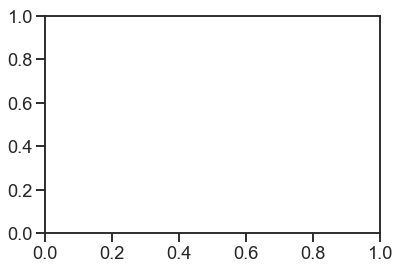

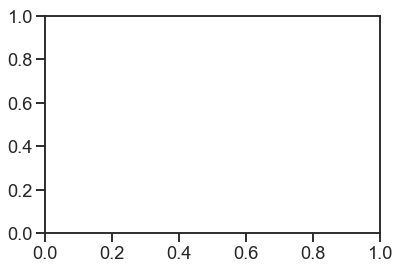

In [267]:
plot_all_spectra(allspec, nplot=2)

In [ ]:
def 
bthru = desimodel.io.load_throughput('b')
rthru = desimodel.io.load_throughput('r')
zthru = desimodel.io.load_throughput('z')

In [ ]:
night, expid = 20191117, 29181
night, expid = 20191117, 29181

In [ ]:
def read_fibermap(night=20191116, expid=28818, fiberassignid=63064):
    strexpid = '{:08d}'.format(expid)
    strfiberassignid = '{:06d}'.format(fiberassignid)
                  
    fiberassignfile = os.path.join(datadir, str(night), strexpid, 'fiberassign-{}.fits'.format(
        strfiberassignid))
    sr = desispec.io.read_frame(specfile)
    return sr

In [ ]:
dir(bthru)

In [ ]:
help(bthru.thru)